<a href="https://colab.research.google.com/github/AmrtanshuBharadwaj/DualVirusEpidemic/blob/main/SF_Self.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

import numpy as np
import networkx as nx
import matplotlib.pylab as plt

from numpy.random import Generator, PCG64, SeedSequence

#--- Set up PRNG: ---
seed= 42                     # Set seed of PRNG state
rg = Generator(PCG64(seed))  # Initialize bit generator (here PCG64) with seed
print(f"PRNG: {rg.bit_generator}")

PRNG: <numpy.random._pcg64.PCG64 object at 0x7f0a51356e50>


MAIN FXN

In [ ]:
import numpy as np
import networkx as nx
import random

def calculate_node_propensities(G, beta, mu, social_distancing_factor):
    # Adjust beta for social distancing

    for node in G.nodes:
        state = G.nodes[node]['state']
        # Susceptible state
        if state == 0:
            infected_neighbors_v1 = sum(G.nodes[neighbor]['state'] == 1 for neighbor in G.neighbors(node))
            infected_neighbors_v2 = sum(G.nodes[neighbor]['state'] == 3 for neighbor in G.neighbors(node))
            lambda_v1 = beta * infected_neighbors_v1
            lambda_v2 = beta * infected_neighbors_v2
            G.nodes[node]['lambda_v1'] = lambda_v1
            G.nodes[node]['lambda_v2'] = lambda_v2
            if lambda_v1 > 0 or lambda_v2 > 0:
                G.nodes[node]['tau'] = -np.log(random.random()) / max(lambda_v1, lambda_v2)
        # Infected state
        elif state == 1 or state == 3:
            G.nodes[node]['lambda'] = mu
            G.nodes[node]['tau'] = -np.log(random.random()) / mu

def draw_next_event_first_reaction(G):
    waiting_times = [(node, G.nodes[node]['tau']) for node in G.nodes if 'tau' in G.nodes[node]]
    # Check if there are no active waiting times
    if not waiting_times:
        return None, None

    # Select the event with the minimal waiting time
    min_node, tau = min(waiting_times, key=lambda x: x[1])
    return min_node, tau

def update_states(G, X, tau, i_selected, beta, mu):
    # Unpack the state counts
    S, I_v1, R_v1, I_v2, R_v2 = X

    # Get the state of the selected node
    state = G.nodes[i_selected]['state']

    # Update the waiting times for the remaining nodes
    for node in G.nodes:
        if 'tau' in G.nodes[node]:
            G.nodes[node]['tau'] -= tau

    # State transitions
    if state == 0:  # Susceptible
        # Determine which virus the node gets infected with
        if G.nodes[i_selected]['lambda_v1'] > G.nodes[i_selected]['lambda_v2']:
            # Infect with V1
            G.nodes[i_selected]['state'] = 1
            I_v1 += 1
            # Update lambda and tau for V1
            G.nodes[i_selected]['lambda'] = mu
            G.nodes[i_selected]['tau'] = -np.log(random.random()) / mu
        else:
            # Infect with V2
            G.nodes[i_selected]['state'] = 3
            I_v2 += 1
            # Update lambda and tau for V2
            G.nodes[i_selected]['lambda'] = mu
            G.nodes[i_selected]['tau'] = -np.log(random.random()) / mu
        S -= 1
    elif state == 1:  # Infected with V1
        # Recover from V1 and gain immunity to V2
        G.nodes[i_selected]['state'] = 2
        I_v1 -= 1
        R_v1 += 1
        # Remove from infection channels
        del G.nodes[i_selected]['lambda']
        del G.nodes[i_selected]['tau']
    elif state == 3:  # Infected with V2
        # Recover from V2 and gain immunity to V1
        G.nodes[i_selected]['state'] = 4
        I_v2 -= 1
        R_v2 += 1
        # Remove from infection channels
        del G.nodes[i_selected]['lambda']
        del G.nodes[i_selected]['tau']

    # Update the propensities of neighbors
    for neighbor in G.neighbors(i_selected):
        if G.nodes[neighbor]['state'] == 0:
            infected_neighbors_v1 = sum(G.nodes[n]['state'] == 1 for n in G.neighbors(neighbor))
            infected_neighbors_v2 = sum(G.nodes[n]['state'] == 3 for n in G.neighbors(neighbor))
            G.nodes[neighbor]['lambda_v1'] = beta * infected_neighbors_v1
            G.nodes[neighbor]['lambda_v2'] = beta * infected_neighbors_v2
            if G.nodes[neighbor]['lambda_v1'] > 0 or G.nodes[neighbor]['lambda_v2'] > 0:
                G.nodes[neighbor]['tau'] = -np.log(random.random()) / max(G.nodes[neighbor]['lambda_v1'], G.nodes[neighbor]['lambda_v2'])

    return [S, I_v1, R_v1, I_v2, R_v2]

def first_reaction_method_SIR_graph_linear(G, beta, mu, T, social_distancing_factor, v2_introduction_threshold):
    # Initialize the state counts
    N = len(G.nodes)
    S = N  # Initially, all nodes are susceptible
    I_v1 = I_v2 = R_v1 = R_v2 = 0

    # Initialize one random node with V1 infection
    initial_infected = random.choice(list(G.nodes))
    G.nodes[initial_infected]['state'] = 1  # Infected with V1
    I_v1 = 1
    S -= 1

    # Initialize node propensities
    calculate_node_propensities(G, beta, mu, social_distancing_factor)

    # Set initial time t = 0
    t = 0

    # Data structure to save the temporal evolution of the states
    X_t = []
    X_t.append([t, S, I_v1, R_v1, I_v2, R_v2])

    # Main simulation loop
    new_beta=beta*(1-social_distancing_factor)

    while t < T:
        # Check if the threshold for V2 introduction is reached
        if ((I_v1+I_v2)/N)>=v2_introduction_threshold:
            beta=new_beta

        if I_v1 >= 0.001 * N and I_v2 == 0:
            # Introduce V2 by infecting a random susceptible node
            susceptible_nodes = [node for node in G.nodes if G.nodes[node]['state'] == 0]
            if susceptible_nodes:
                v2_initial_infected = random.choice(susceptible_nodes)
                G.nodes[v2_initial_infected]['state'] = 3  # Infected with V2
                I_v2 = 1
                S -= 1
                calculate_node_propensities(G, beta, mu, social_distancing_factor)

        # Check if there are no more reactions to occur
        if not any('tau' in G.nodes[node] for node in G.nodes):
            break

        # Select the next event
        i_selected, tau = draw_next_event_first_reaction(G)
        if i_selected is None:
            break

        # Update time
        t += tau

        # Update the states and counts
        state_counts = update_states(G, [S, I_v1, R_v1, I_v2, R_v2], tau, i_selected, beta, mu)
        S, I_v1, R_v1, I_v2, R_v2 = state_counts

        # Record the state counts
        X_t.append([t, S, I_v1, R_v1, I_v2, R_v2])

    return np.array(X_t).transpose()

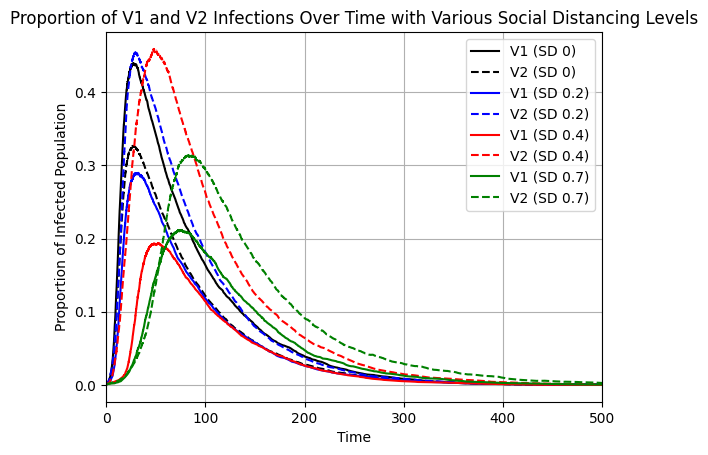

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

# Simulation parameters
beta = 0.037  # Infection rate
mu = 0.0148   # Recovery rate
k = 10       # Mean degree
N = 800     # Number of nodes
T =500      # Simulation duration
Q = 10      # Number of simulations
v2_introduction_threshold = 0.0012  # Threshold for introducing V2 (0.1% of the population)

# Social distancing factors
sd_factors = [0, 0.2, 0.4, 0.7]
sd_colors = ['black', 'blue', 'red', 'green']  # Different color for each SD factor

# Create initial network
G0 = nx.barabasi_albert_graph(n=N, m=int(k/2))

fig = plt.figure()
ax = plt.subplot()

# Loop over each social distancing factor once
for sd_factor, color in zip(sd_factors, sd_colors):
    # Store simulation results for this SD factor
    X_array = []

    for q in range(Q):
        G = G0.copy()
        nx.set_node_attributes(G, 0, 'state')  # Set all nodes to susceptible initially

        # Run the simulation with the current SD factor
        X_t = first_reaction_method_SIR_graph_linear(G, beta, mu, T, sd_factor, v2_introduction_threshold)
        X_array.append(X_t)

    # Interpolating and averaging for each SD factor
    common_time = []
    for X in X_array:
        common_time.extend(X[0])
    common_time = list(set(common_time))
    common_time.sort()

    interpolated_i_v1_values = []
    interpolated_i_v2_values = []

    for X in X_array:
        f_i_v1 = interpolate.interp1d(X[0], X[2], kind='linear', bounds_error=False, fill_value=0)
        f_i_v2 = interpolate.interp1d(X[0], X[4], kind='linear', bounds_error=False, fill_value=0)

        interpolated_i_v1_values.append(f_i_v1(common_time))
        interpolated_i_v2_values.append(f_i_v2(common_time))

    # Correcting negative values post-interpolation
    average_i_v1 = np.maximum(0, np.mean(interpolated_i_v1_values, axis=0) / N)
    average_i_v2 = np.maximum(0, np.mean(interpolated_i_v2_values, axis=0) / N)

    # Plotting for this SD factor
    ax.plot(common_time, average_i_v1, c=color, linestyle='-', label=f'V1 (SD {sd_factor})')
    ax.plot(common_time, average_i_v2, c=color, linestyle='--', label=f'V2 (SD {sd_factor})')

# Set x-axis limit to show only up to T
plt.xlim(0, T)

plt.xlabel('Time')
plt.ylabel('Proportion of Infected Population')
plt.title('Proportion of V1 and V2 Infections Over Time with Various Social Distancing Levels')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.grid()
plt.show()


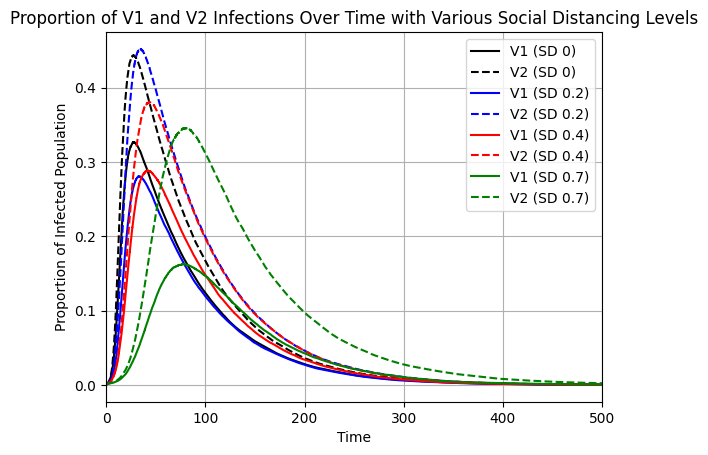

In [ ]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

# Simulation parameters
beta = 0.037  # Infection rate
mu = 0.0148   # Recovery rate
k = 10       # Mean degree
N = 800     # Number of nodes
T = 500      # Simulation duration
Q = 100      # Number of simulations
v2_introduction_threshold = 0.0012  # Threshold for introducing V2 (0.1% of the population)

# Social distancing factors
sd_factors = [0, 0.2, 0.4, 0.7]
sd_colors = ['black', 'blue', 'red', 'green']  # Different color for each SD factor

# Create initial network
G0 = nx.barabasi_albert_graph(n=N, m=int(k/2))

fig = plt.figure()
ax = plt.subplot()

# Loop over each social distancing factor once
for sd_factor, color in zip(sd_factors, sd_colors):
    # Store simulation results for this SD factor
    X_array = []

    for q in range(Q):
        G = G0.copy()
        nx.set_node_attributes(G, 0, 'state')  # Set all nodes to susceptible initially

        # Run the simulation with the current SD factor
        X_t = first_reaction_method_SIR_graph_linear(G, beta, mu, T, sd_factor, v2_introduction_threshold)
        X_array.append(X_t)

    # Interpolating and averaging for each SD factor
    common_time = []
    for X in X_array:
        common_time.extend(X[0])
    common_time = list(set(common_time))
    common_time.sort()

    interpolated_i_v1_values = []
    interpolated_i_v2_values = []

    for X in X_array:
        f_i_v1 = interpolate.interp1d(X[0], X[2], kind='linear', bounds_error=False, fill_value=0)
        f_i_v2 = interpolate.interp1d(X[0], X[4], kind='linear', bounds_error=False, fill_value=0)

        interpolated_i_v1_values.append(f_i_v1(common_time))
        interpolated_i_v2_values.append(f_i_v2(common_time))

    # Correcting negative values post-interpolation
    average_i_v1 = np.maximum(0, np.mean(interpolated_i_v1_values, axis=0) / N)
    average_i_v2 = np.maximum(0, np.mean(interpolated_i_v2_values, axis=0) / N)

    # Plotting for this SD factor
    ax.plot(common_time, average_i_v1, c=color, linestyle='-', label=f'V1 (SD {sd_factor})')
    ax.plot(common_time, average_i_v2, c=color, linestyle='--', label=f'V2 (SD {sd_factor})')

# Set x-axis limit to show only up to T
plt.xlim(0, T)

plt.xlabel('Time')
plt.ylabel('Proportion of Infected Population')
plt.title('Proportion of V1 and V2 Infections Over Time with Various Social Distancing Levels')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.grid()
plt.show()


V2/(V1+V2)

TEST